# 1. Setup

## 1.1 Install Dependencies

In [2]:
from numba import cuda


device = cuda.get_current_device()
print(device)


<CUDA device 0 'b'NVIDIA GeForce GTX 1650 SUPER''>


## 1.2 Import Dependencies

In [78]:
# Import standard dependencies
import cv2
import os
import random
import numpy as np
from matplotlib import pyplot as plt

In [4]:
# Import tensorflow dependencies - Functional API
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf

## 1.3 Set GPU Growth

In [5]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

[]


## 1.4 Create Folder Structures

In [9]:
# Setup paths
POS_PATH = os.path.join('data', 'positive')
NEG_PATH = os.path.join('data', 'negative')
ANC_PATH = os.path.join('data', 'anchor')

In [13]:
# Make the directories
os.makedirs(POS_PATH)
os.makedirs(NEG_PATH)
os.makedirs(ANC_PATH)

# 2. Collect Positives and Anchors

## 2.1 Untar Labelled Faces in the Wild Dataset

In [14]:
# http://vis-www.cs.umass.edu/lfw/

In [15]:
# Uncompress Tar GZ Labelled Faces in the Wild Dataset
!tar -xf lfw.tgz

In [6]:
# Move LFW Images to the following repository data/negative
for directory in os.listdir('lfw'):
    for file in os.listdir(os.path.join('lfw', directory)):
        EX_PATH = os.path.join('lfw', directory, file)
        NEW_PATH = os.path.join(NEG_PATH, file)
        os.replace(EX_PATH, NEW_PATH)

## 2.2 Collect Positive and Anchor Classes

In [7]:
# Import uuid library to generate unique image names
import uuid

In [10]:
os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))

'data\\anchor\\43e9a948-ae4c-11ee-b51d-ec87ddbbf22b.jpg'

In [11]:
# Establish a connection to the webcam
cap = cv2.VideoCapture(0)

while cap.isOpened(): 
    ret, frame = cap.read()
    print(frame,'asdasd')
    # Cut down frame to 250x250px
    frame = frame[120:120+250,200:200+250, :]
    
    # Collect anchors 
    if cv2.waitKey(1) & 0XFF == ord('a'):
        # Create the unique file path 
        imgname = os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))
        # Write out anchor image
        cv2.imwrite(imgname, frame)
    
    # Collect positives
    if cv2.waitKey(1) & 0XFF == ord('p'):
        # Create the unique file path 
        imgname = os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1()))
        # Write out positive image
        cv2.imwrite(imgname, frame)
    
    # Show image back to screen
    cv2.imshow('Image Collection', frame)
    
    # Breaking gracefully
    if cv2.waitKey(1) & 0XFF == ord('q'):
        break
        
# Release the webcam
cap.release()
# Close the image show frameb
cv2.destroyAllWindows()

[[[23 38 30]
  [23 38 30]
  [23 38 30]
  ...
  [30 35 18]
  [29 34 17]
  [30 34 17]]

 [[23 38 30]
  [23 38 30]
  [23 39 29]
  ...
  [32 38 21]
  [32 37 20]
  [32 37 20]]

 [[23 38 30]
  [23 39 29]
  [23 39 29]
  ...
  [33 40 23]
  [33 39 22]
  [34 39 22]]

 ...

 [[10 20 18]
  [ 9 19 17]
  [ 8 17 15]
  ...
  [21 42 26]
  [22 44 26]
  [22 45 25]]

 [[14 22 19]
  [13 21 18]
  [12 20 17]
  ...
  [23 44 29]
  [25 47 29]
  [26 48 30]]

 [[10 17 14]
  [10 17 14]
  [11 18 15]
  ...
  [21 42 27]
  [23 45 28]
  [25 47 29]]] asdasd
[[[117 123 106]
  [117 123 106]
  [118 124 107]
  ...
  [133 127  91]
  [135 128  92]
  [136 128  91]]

 [[117 123 105]
  [117 123 105]
  [117 123 105]
  ...
  [133 127  91]
  [135 128  92]
  [136 128  91]]

 [[116 122 104]
  [117 123 105]
  [117 123 105]
  ...
  [133 127  91]
  [135 128  92]
  [136 128  91]]

 ...

 [[ 61  51  47]
  [ 57  47  43]
  [ 51  41  37]
  ...
  [101 112 110]
  [101 112 110]
  [102 113 111]]

 [[ 34  26  21]
  [ 45  37  32]
  [ 59  51  46]
 

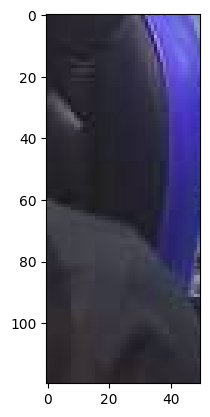

In [13]:
plt.imshow(frame[120:120+250,200:200+250, :])

# 2.x NEW - Data Augmentation

In [14]:
def data_aug(img):
    data = []
    for i in range(9):
        img = tf.image.stateless_random_brightness(img, max_delta=0.02, seed=(1,2))
        img = tf.image.stateless_random_contrast(img, lower=0.6, upper=1, seed=(1,3))
        # img = tf.image.stateless_random_crop(img, size=(20,20,3), seed=(1,2))
        img = tf.image.stateless_random_flip_left_right(img, seed=(np.random.randint(100),np.random.randint(100)))
        img = tf.image.stateless_random_jpeg_quality(img, min_jpeg_quality=90, max_jpeg_quality=100, seed=(np.random.randint(100),np.random.randint(100)))
        img = tf.image.stateless_random_saturation(img, lower=0.9,upper=1, seed=(np.random.randint(100),np.random.randint(100)))
            
        data.append(img)
    
    return data

In [15]:
import os
import uuid

In [23]:

for file_name in os.listdir(os.path.join(ANC_PATH)):
    img_path = os.path.join(ANC_PATH, file_name)
    img = cv2.imread(img_path)
    augmented_images = data_aug(img) 
    
    for image in augmented_images:
        cv2.imwrite(os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1())), image.numpy())

In [83]:
for file_name in os.listdir(os.path.join(POS_PATH)):
    img_path = os.path.join(POS_PATH, file_name)
    img = cv2.imread(img_path)
    augmented_images = data_aug(img) 
    
    for image in augmented_images:
        cv2.imwrite(os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1())), image.numpy())

# 3. Load and Preprocess Images

## 3.1 Get Image Directories

In [16]:
anchor = tf.data.Dataset.list_files(ANC_PATH+'\*.jpg').take(3000)
positive = tf.data.Dataset.list_files(POS_PATH+'\*.jpg').take(3000)
negative = tf.data.Dataset.list_files(NEG_PATH+'\*.jpg').take(3000)

In [17]:
dir_test = anchor.as_numpy_iterator()

In [18]:
print(dir_test.next())

b'data\\anchor\\a989cdb1-addc-11ee-b2ba-dcded240b039.jpg'


## 3.2 Preprocessing - Scale and Resize

In [73]:
@cuda.jit
def normalize_image_cuda(image, normalized):
    x, y, z = cuda.grid(3)
    if x < image.shape[0] and y < image.shape[1] and z < image.shape[2]:
        normalized[x, y, z] = image[x, y, z] / 255.0

In [74]:
def preprocess(file_path):
    # Read in image from file path
    byte_img = tf.io.read_file(file_path)
    # Load in the image 
    img = tf.io.decode_jpeg(byte_img)
    
    # Preprocessing steps - resizing the image to be 100x100x3
    img = tf.image.resize(img, (100,100))
    
    # Convert TensorFlow image to numpy array for CUDA processing
    img_np = img.numpy()

    # Allocate memory on the device
    image_device = cuda.to_device(img_np)
    normalized_device = cuda.device_array(img_np.shape, np.float32)

    # Configure the blocks
    threads_per_block = (8, 8, 3)
    blocks_per_grid_x = int(np.ceil(img_np.shape[0] / threads_per_block[0]))
    blocks_per_grid_y = int(np.ceil(img_np.shape[1] / threads_per_block[1]))
    blocks_per_grid_z = int(np.ceil(img_np.shape[2] / threads_per_block[2]))
    blocks_per_grid = (blocks_per_grid_x, blocks_per_grid_y, blocks_per_grid_z)

    # Normalize the image using CUDA
    normalize_image_cuda[blocks_per_grid, threads_per_block](image_device, normalized_device)

    # Copy the normalized image back to the host
    normalized_img = normalized_device.copy_to_host()

    # Return the normalized image
    return normalized_img

In [19]:
# def preprocess(file_path):
    
#     # Read in image from file path
#     byte_img = tf.io.read_file(file_path)
#     # Load in the image 
#     img = tf.io.decode_jpeg(byte_img)
    
#     # Preprocessing steps - resizing the image to be 100x100x3
#     img = tf.image.resize(img, (100,100))
#     # Scale image to be between 0 and 1 
#     img = img / 255.0

#     # Return image
#     return img

In [75]:
img=preprocess('data\\anchor\\a61b64ef-addc-11ee-bd14-dcded240b039.jpg')

In [ ]:
# dataset.map(preprocess)

## 3.3 Create Labelled Dataset

In [ ]:
# (anchor, positive) => 1,1,1,1,1
# (anchor, negative) => 0,0,0,0,0

In [23]:
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [24]:
samples = data.as_numpy_iterator()

In [25]:
exampple = samples.next()

In [26]:
exampple

(b'data\\anchor\\a23bb9b7-addc-11ee-a4c1-dcded240b039.jpg',
 b'data\\positive\\b4121c23-addc-11ee-9b6c-dcded240b039.jpg',
 1.0)

## 3.4 Build Train and Test Partition

In [27]:
def preprocess_twin(input_img, validation_img, label):
    return(preprocess(input_img), preprocess(validation_img), label)

In [28]:
res = preprocess_twin(*exampple)

In [30]:
res[2]

1.0

In [31]:
# Build dataloader pipeline
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=10000)

In [32]:
# Training partition
train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [33]:
# Testing partition
test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

# 4. Model Engineering

## 4.1 Build Embedding Layer

In [34]:
inp = Input(shape=(100,100,3), name='input_image')

In [35]:
c1 = Conv2D(64, (10,10), activation='relu')(inp)

In [36]:
m1 = MaxPooling2D(64, (2,2), padding='same')(c1)

In [37]:
c2 = Conv2D(128, (7,7), activation='relu')(m1)
m2 = MaxPooling2D(64, (2,2), padding='same')(c2)

In [38]:
c3 = Conv2D(128, (4,4), activation='relu')(m2)
m3 = MaxPooling2D(64, (2,2), padding='same')(c3)

In [39]:
c4 = Conv2D(256, (4,4), activation='relu')(m3)
f1 = Flatten()(c4)
d1 = Dense(4096, activation='sigmoid')(f1)

In [40]:
mod = Model(inputs=[inp], outputs=[d1], name='embedding')

In [41]:
mod.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 100, 100, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 91, 91, 64)        19264     
                                                                 
 max_pooling2d (MaxPooling2  (None, 46, 46, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 40, 40, 128)       401536    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 20, 20, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 17, 17, 128)       26

In [42]:
def make_embedding(): 
    inp = Input(shape=(100,100,3), name='input_image')
    
    # First block
    c1 = Conv2D(64, (10,10), activation='relu')(inp)
    m1 = MaxPooling2D(64, (2,2), padding='same')(c1)
    
    # Second block
    c2 = Conv2D(128, (7,7), activation='relu')(m1)
    m2 = MaxPooling2D(64, (2,2), padding='same')(c2)
    
    # Third block 
    c3 = Conv2D(128, (4,4), activation='relu')(m2)
    m3 = MaxPooling2D(64, (2,2), padding='same')(c3)
    
    # Final embedding block
    c4 = Conv2D(256, (4,4), activation='relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation='sigmoid')(f1)
    
    
    return Model(inputs=[inp], outputs=[d1], name='embedding')

In [43]:
embedding = make_embedding()

In [44]:
embedding.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 100, 100, 3)]     0         
                                                                 
 conv2d_4 (Conv2D)           (None, 91, 91, 64)        19264     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 46, 46, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 40, 40, 128)       401536    
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 20, 20, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 17, 17, 128)       26

## 4.2 Build Distance Layer

In [45]:
# Siamese L1 Distance class
class L1Dist(Layer):
    
    # Init method - inheritance
    def __init__(self, **kwargs):
        super().__init__()
       
    # Magic happens here - similarity calculation
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)

In [46]:
l1 = L1Dist()

In [47]:
l1

## 4.3 Make Siamese Model

In [48]:
input_image = Input(name='input_img', shape=(100,100,3))
validation_image = Input(name='validation_img', shape=(100,100,3))

In [49]:
inp_embedding = embedding(input_image)
val_embedding = embedding(validation_image)

In [50]:
siamese_layer = L1Dist()

In [51]:
distances = siamese_layer(inp_embedding, val_embedding)

In [52]:
classifier = Dense(1, activation='sigmoid')(distances)

In [53]:
classifier

<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'dense_2')>

In [54]:
siamese_network = Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [55]:
siamese_network.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_img (InputLayer)      [(None, 100, 100, 3)]        0         []                            
                                                                                                  
 validation_img (InputLayer  [(None, 100, 100, 3)]        0         []                            
 )                                                                                                
                                                                                                  
 embedding (Functional)      (None, 4096)                 3896044   ['input_img[0][0]',           
                                                          8          'validation_img[0][0]']      
                                                                                     

In [56]:
def make_siamese_model(): 
    
    # Anchor image input in the network
    input_image = Input(name='input_img', shape=(100,100,3))
    
    # Validation image in the network 
    validation_image = Input(name='validation_img', shape=(100,100,3))
    
    # Combine siamese distance components
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(embedding(input_image), embedding(validation_image))
    
    # Classification layer 
    classifier = Dense(1, activation='sigmoid')(distances)
    
    return Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [57]:
siamese_model = make_siamese_model()

In [58]:
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_img (InputLayer)      [(None, 100, 100, 3)]        0         []                            
                                                                                                  
 validation_img (InputLayer  [(None, 100, 100, 3)]        0         []                            
 )                                                                                                
                                                                                                  
 embedding (Functional)      (None, 4096)                 3896044   ['input_img[0][0]',           
                                                          8          'validation_img[0][0]']      
                                                                                     

# 5. Training

## 5.1 Setup Loss and Optimizer

In [59]:
binary_cross_loss = tf.losses.BinaryCrossentropy()

In [60]:
opt = tf.keras.optimizers.Adam(1e-4) # 0.0001

## 5.2 Establish Checkpoints

In [61]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model=siamese_model)

## 5.3 Build Train Step Function

In [62]:
test_batch = train_data.as_numpy_iterator()

In [63]:
batch_1 = test_batch.next()

In [64]:
X = batch_1[:2]

In [65]:
y = batch_1[2]

In [66]:
y

array([0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 1., 1., 0., 1.],
      dtype=float32)

In [67]:
tf.losses.BinaryCrossentropy??

Init signature:
tf.losses.BinaryCrossentropy(
    from_logits=False,
    label_smoothing=0.0,
    axis=-1,
    reduction='auto',
    name='binary_crossentropy',
)
Source:        
@keras_export("keras.losses.BinaryCrossentropy")
class BinaryCrossentropy(LossFunctionWrapper):
    """Computes the cross-entropy loss between true labels and predicted labels.

    Use this cross-entropy loss for binary (0 or 1) classification applications.
    The loss function requires the following inputs:

    - `y_true` (true label): This is either 0 or 1.
    - `y_pred` (predicted value): This is the model's prediction, i.e, a single
        floating-point value which either represents a
        [logit](https://en.wikipedia.org/wiki/Logit), (i.e, value in [-inf, inf]
        when `from_logits=True`) or a probability (i.e, value in [0., 1.] when
        `from_logits=False`).

    **Recommended Usage:** (set `from_logits=True`)

    With `tf.keras` API:

    ```python
    model.compile(
        loss=tf.ke

In [68]:
@tf.function
def train_step(batch):
    
    # Record all of our operations 
    with tf.GradientTape() as tape:     
        # Get anchor and positive/negative image
        X = batch[:2]
        # Get label
        y = batch[2]
        
        # Forward pass
        yhat = siamese_model(X, training=True)
        # Calculate loss
        loss = binary_cross_loss(y, yhat)
    print(loss)
        
    # Calculate gradients
    grad = tape.gradient(loss, siamese_model.trainable_variables)
    
    # Calculate updated weights and apply to siamese model
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))
        
    # Return loss
    return loss

## 5.4 Build Training Loop

In [69]:
# Import metric calculations
from tensorflow.keras.metrics import Precision, Recall

In [70]:
def train(data, EPOCHS):
    # Loop through epochs
    for epoch in range(1, EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))
        
        # Creating a metric object 
        r = Recall()
        p = Precision()
        
        # Loop through each batch
        for idx, batch in enumerate(data):
            # Run train step here
            loss = train_step(batch)
            yhat = siamese_model.predict(batch[:2])
            r.update_state(batch[2], yhat)
            p.update_state(batch[2], yhat) 
            progbar.update(idx+1)
        print(loss.numpy(), r.result().numpy(), p.result().numpy())
        
        # Save checkpoints
        if epoch % 10 == 0: 
            checkpoint.save(file_prefix=checkpoint_prefix)

## 5.5 Train the model

In [80]:
EPOCHS = 2


In [81]:
train_data

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 100, 100, None), dtype=tf.float32, name=None), TensorSpec(shape=(None, 100, 100, None), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.float32, name=None))>

In [ ]:
train(train_data, EPOCHS)


 Epoch 1/2
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
263/263 [==============================] - 546s 2s/step
0.04568032 0.94504464 0.99308985

 Epoch 2/2
247/263 [===========================>..] - ETA: 34s

# 6. Evaluate Model

## 6.1 Import Metrics

In [101]:
# Import metric calculations
from tensorflow.keras.metrics import Precision, Recall

## 6.2 Make Predictions

In [102]:
# Get a batch of test data
test_input, test_val, y_true = test_data.as_numpy_iterator().next()

In [103]:
y_hat = siamese_model.predict([test_input, test_val])

1/1 [==============================] - 0s 300ms/step


In [104]:
# Post processing the results 
[1 if prediction > 0.5 else 0 for prediction in y_hat ]

[0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0]

In [105]:
y_true

array([0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0.],
      dtype=float32)

## 6.3 Calculate Metrics

In [106]:
# Creating a metric object 
m = Recall()

# Calculating the recall value 
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

1.0

In [107]:
# Creating a metric object 
m = Precision()

# Calculating the recall value 
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

1.0

In [108]:
r = Recall()
p = Precision()

for test_input, test_val, y_true in test_data.as_numpy_iterator():
    yhat = siamese_model.predict([test_input, test_val])
    r.update_state(y_true, yhat)
    p.update_state(y_true,yhat) 

print(r.result().numpy(), p.result().numpy())

1/1 [==============================] - 0s 102ms/step
0.9781421 0.98895025


## 6.4 Viz Results

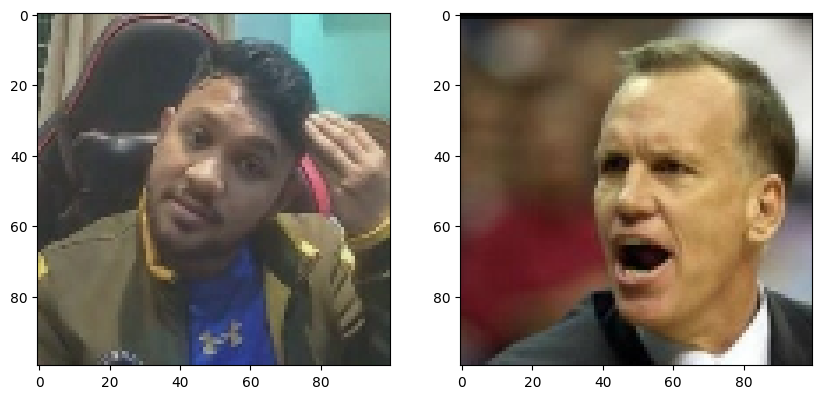

In [114]:
# Set plot size 
plt.figure(figsize=(10,8))

# Set first subplot
plt.subplot(1,2,1)
plt.imshow(test_input[1])

# Set second subplot
plt.subplot(1,2,2)
plt.imshow(test_val[1])

# Renders cleanly
plt.show()

# 7. Save Model

In [115]:
# Save weights
siamese_model.save('siamesemodelv2.h5')

P:\Thesis Code\thesis\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [116]:
L1Dist

__main__.L1Dist

In [117]:
# Reload model 
siamese_model = tf.keras.models.load_model('siamesemodelv2.h5', 
                                   custom_objects={'L1Dist':L1Dist, 'BinaryCrossentropy':tf.losses.BinaryCrossentropy})

In [118]:
# Make predictions with reloaded model
siamese_model.predict([test_input, test_val])

1/1 [==============================] - 0s 186ms/step


array([[8.4532881e-01],
       [1.8072656e-06],
       [2.2502590e-03],
       [9.9999994e-01]], dtype=float32)

In [119]:
# View model summary
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_img (InputLayer)      [(None, 100, 100, 3)]        0         []                            
                                                                                                  
 validation_img (InputLayer  [(None, 100, 100, 3)]        0         []                            
 )                                                                                                
                                                                                                  
 embedding (Functional)      (None, 4096)                 3896044   ['input_img[0][0]',           
                                                          8          'validation_img[0][0]']      
                                                                                     

# 8. Real Time Test

## 8.1 Verification Function

In [143]:
os.listdir(os.path.join('application_data', 'verification_images'))

['9a021958-addd-11ee-9332-dcded240b039.jpg',
 '9a026786-addd-11ee-b2f6-dcded240b039.jpg',
 '9a02a22c-addd-11ee-9968-dcded240b039.jpg',
 '9a02dcd2-addd-11ee-9abc-dcded240b039.jpg',
 '9a031773-addd-11ee-99bc-dcded240b039.jpg',
 '9a03521a-addd-11ee-8c4d-dcded240b039.jpg',
 '9a037932-addd-11ee-b8c8-dcded240b039.jpg',
 '9a03b3d8-addd-11ee-a29e-dcded240b039.jpg',
 '9a03ee7e-addd-11ee-811f-dcded240b039.jpg',
 '9a081aa6-addc-11ee-a8e3-dcded240b039.jpg',
 '9a0f62de-addd-11ee-a3c0-dcded240b039.jpg',
 '9a0fb111-addd-11ee-9577-dcded240b039.jpg',
 '9a0febb3-addd-11ee-a7b7-dcded240b039.jpg',
 '9a10265a-addd-11ee-9509-dcded240b039.jpg',
 '9a1060f8-addd-11ee-8418-dcded240b039.jpg',
 '9a109ba3-addd-11ee-844b-dcded240b039.jpg',
 '9a10d649-addd-11ee-afd1-dcded240b039.jpg',
 '9a1110ef-addd-11ee-b104-dcded240b039.jpg',
 '9a115f1d-addd-11ee-97c3-dcded240b039.jpg',
 '9a1e6e0f-addd-11ee-a0a4-dcded240b039.jpg',
 '9a1ea8b7-addd-11ee-ad5b-dcded240b039.jpg',
 '9a1ef6e5-addd-11ee-a26b-dcded240b039.jpg',
 '9a1f318b

In [144]:
def verify(model, detection_threshold, verification_threshold):
    # Build results array
    results = []
    for image in os.listdir(os.path.join('application_data', 'verification_images')):
        input_img = preprocess(os.path.join('application_data', 'input_image', 'input_image.jpg'))
        validation_img = preprocess(os.path.join('application_data', 'verification_images', image))
        
        # Make Predictions 
        result = model.predict(list(np.expand_dims([input_img, validation_img], axis=1)))
        results.append(result)
    
    # Detection Threshold: Metric above which a prediciton is considered positive 
    detection = np.sum(np.array(results) > detection_threshold)
    
    # Verification Threshold: Proportion of positive predictions / total positive samples 
    verification = detection / len(os.listdir(os.path.join('application_data', 'verification_images'))) 
    verified = verification > verification_threshold
    
    return results, verified

## 8.2 OpenCV Real Time Verification

In [147]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()
    frame = frame[120:120+250,200:200+250, :]
    
    cv2.imshow('Verification', frame)
    
    # Verification trigger
    if cv2.waitKey(10) & 0xFF == ord('v'):
        # Save input image to application_data/input_image folder 
#         hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
#         h, s, v = cv2.split(hsv)

#         lim = 255 - 10
#         v[v > lim] = 255
#         v[v <= lim] -= 10
        
#         final_hsv = cv2.merge((h, s, v))
#         img = cv2.cvtColor(final_hsv, cv2.COLOR_HSV2BGR)

        cv2.imwrite(os.path.join('application_data', 'input_image', 'input_image.jpg'), frame)
        # Run verification
        results, verified = verify(siamese_model, 0.5, 0.5)
        print(verified)
    
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

1/1 [==============================] - 0s 51ms/step
True
1/1 [==============================] - 0s 52ms/step
True


In [ ]:
np.sum(np.squeeze(results) > 0.9)

In [ ]:
results